# ESM Embeddigs

Given a sequence such as ABCDE, using ESM, get the embeddings for each aminoacid. Assume that mutbpe tokenizer segments this sequence into AB CDE and we know that our mutator is able to mutate AB into AN. Get the embeddings for sequence ANCDE. 
- Compare the embeddings of N and B. We expect the change in embeddings should be smaller compared to say any "non-mutbpe" mutation for B. It is possible to also consider the score or the observed frequency of this mutation during the training of mutBPE. Do the mutation scores or frequencies correlate positively with the change in embedding vectors?
- Observe the changes in embeddings of other aminoacids after the mutation. Also possible to consider "up to a range". How local or a global impact does this particular mutation have?

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_HOME"] = "/cta/share/users/esm"

In [2]:
from time import time
import sqlite3
import pandas as pd
from tqdm import tqdm
import numpy as np
from tokenizers import Tokenizer
import json
from collections import Counter
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import random
from pandarallel import pandarallel
from protein_embedding_database import ProteinEmbeddingDatabase
from EfficientBPE.vocabulary_functions import get_mutated, get_parents, set_difference, set_intersection, load_tokenizers, calc_agreement, calc_dice_idx_only

In [3]:
pandarallel.initialize(progress_bar=True, nb_workers=20)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.get_device_name(0)

(True, 1, 0, 'NVIDIA RTX A6000')

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Get Embeddings

In [6]:
# facebook/model_name
# Checkpoint name	    Num layers  Num parameters  Dim count   Have DB
# esm2_t48_15B_UR50D	48	        15B             -           No
# esm2_t36_3B_UR50D	    36          3B              -           No
# esm2_t33_650M_UR50D	33          650M            1280        Yes
# esm2_t30_150M_UR50D	30          150M            640         Yes
# esm2_t12_35M_UR50D	12          35M             480         No
# esm2_t6_8M_UR50D	    6           8M              320         Yes
model_name = "facebook/esm2_t33_650M_UR50D"

In [7]:
# def get_embeddings(text, model_name="facebook/esm2_t6_8M_UR50D"):
#     """
#     Compute embeddings for each token in the text using a specified model.
    
#     Parameters:
#     - text (str): The input text for which embeddings need to be computed.
#     - model_name (str): The path to the pretrained model.
    
#     Returns:
#     - numpy.ndarray: A matrix where each row is the embedding of a token in the text.
#     """
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)

#     # inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=1024)
#     inputs = tokenizer(text, return_tensors="pt")
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Return embeddings after removing <cls> and <eos> tokens and converting to numpy.
#     return outputs.last_hidden_state[:, 1:-1, :].squeeze(0).numpy()

def get_esm_embeddings_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    return tokenizer, model

def get_esm_embeddings(text, tokenizer, model, ):
    # inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=1024)
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Return embeddings after removing <cls> and <eos> tokens and converting to numpy.
    return outputs.last_hidden_state.to('cpu')[:, 1:-1, :].squeeze(0).numpy()

In [8]:
esm_tokenizer, esm_model = get_esm_embeddings_model(model_name)
esm_model.to(device);

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
get_esm_embeddings("PVNPCCYYPCXA", esm_tokenizer, esm_model).shape

(12, 1280)

## Load ESM Embeddings Faiss DB

In [10]:
# def load_protein_embedding_db(model_name, root_path="/cta/share/users/uniprot/human/faiss"):
#     faiss_path = f"{root_path}/{model_name.replace('/', '_')}_protein_embeddings.faiss"
#     id_map_path = f"{root_path}/{model_name.replace('/', '_')}_id_mapping.csv"
#     loaded_db = ProteinEmbeddingDatabase.load_database(faiss_path, id_map_path, model_name)

#     return loaded_db

# loaded_db = load_protein_embedding_db(model_name)

In [11]:
# def get_aminoacid_embedding(uniprot_id, aa_index):
#     return loaded_db.get_amino_acid_embedding(f"{uniprot_id}_{aa_index}")

# def get_protein_embedding(uniprot_id, sequence_len):
#     return np.array([loaded_db.get_amino_acid_embedding(f"{uniprot_id}_{i}")for i in range(sequence_len)])

# def get_protein_embedding_slice(uniprot_id, start_index, end_index):
#     return np.array([loaded_db.get_amino_acid_embedding(f"{uniprot_id}_{i}")for i in range(start_index, end_index)])

In [12]:
# %timeit get_aminoacid_embedding('F8WC80', 3)

## Load Datasets

In [13]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

uniref_id = '50'
df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 1024].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

# df_interpro_domain = pd.read_sql(f"SELECT uniprot_id, interpro_id as source, start_index, end_index FROM interpro_entries_v2 WHERE type='domain'", conn)
# df_ted = pd.read_sql(f"SELECT uniprot_id, ted_id as source, start_index, end_index FROM ted_entries_summary WHERE plddt >= 70", conn)

conn.close()

In [14]:
# df_domains = pd.concat([df_interpro_domain, df_ted])
# interpro_ids = df_domains.loc[df_domains["source"].str.startswith("IPR"), "uniprot_id"].unique() # Find uniprot_ids that have "interpro" as a source
# df_domains = df_domains[~((df_domains["uniprot_id"].isin(interpro_ids)) & (df_domains["source"].str.startswith("AF")))] # Filter the DataFrame to exclude rows with source "ted" for those uniprot_ids
# df_domains = df_protein.set_index('uniprot_id').join(df_domains.set_index('uniprot_id'), how='inner').reset_index()
# df_domains['domain_sequence'] = df_domains.apply(lambda row: row['sequence'][row['start_index']-1: row['end_index']], axis=1)
# df_domains = df_domains[df_domains['domain_sequence'].str.len()>0].reset_index(drop=True)

# # df_domains = df_domains[df_domains['source'].str.startswith('IPR')] # just keep interpro entries
# # df_domains = df_domains[['uniprot_id', 'source', 'domain_sequence']].reset_index(drop=True)
# df_domains

## Load Tokenizers

In [15]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.05,. 0.005}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600, 51200]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.005,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.8,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

In [16]:
tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')
methods = [method_name[:-len(str(vocab_sizes[0]))-1] for method_name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn:mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}
methods2names

vocab_list = {}
for name, tokenizer in tokenizer_list.items():
    vocab_list[name] = list(set([token for token, idx in tokenizer.get_vocab().items()]))


inner_vocab_parents_list = {}
inner_vocab_mutated_list = {}
inner_vocab_family_list = {}
for k, v in inner_vocab_list.items():
    inner_vocab_parents_list[k] = get_parents(v)
    inner_vocab_mutated_list[k] = get_mutated(v)
    inner_vocab_family_list[k] = {p:0 for p in inner_vocab_parents_list[k].keys()}

In [17]:
for tokenizer_name in tokenizer_list.keys():
    for mutated_token, mutated_token_attr in inner_vocab_mutated_list[tokenizer_name].items():
        parent_token = mutated_token_attr['parent']
        inner_vocab_parents_list[tokenizer_name][parent_token]['mutations'] = inner_vocab_parents_list[tokenizer_name][parent_token].get('mutations', []) + [mutated_token]

In [18]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

100%|██████████| 21/21 [00:44<00:00,  2.11s/it]


In [19]:
df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein.head()

,uniprot_id,sequence,mutBPE pam70 0.7 0.005 800,mutBPE pam70 0.7 0.005 1600,mutBPE pam70 0.7 0.005 3200,mutBPE pam70 0.7 0.005 6400,mutBPE pam70 0.7 0.005 12800,mutBPE pam70 0.7 0.005 25600,mutBPE pam70 0.7 0.005 51200,mutBPE pam70 0.8 0.05 800,...,mutBPE pam70 0.8 0.05 12800,mutBPE pam70 0.8 0.05 25600,mutBPE pam70 0.8 0.05 51200,mutBPE pre pam70 0.7 0.05 800,mutBPE pre pam70 0.7 0.05 1600,mutBPE pre pam70 0.7 0.05 3200,mutBPE pre pam70 0.7 0.05 6400,mutBPE pre pam70 0.7 0.05 12800,mutBPE pre pam70 0.7 0.05 25600,mutBPE pre pam70 0.7 0.05 51200
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,"[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...",...,"[MEL, SA, EYL, REKL, QR, DLEA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG..."
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"[M, GL, EAL, V, PL, A, MI, VA, IF, LLL, V, DL,...","[M, GL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH,...","[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[M, GL, EAL, V, PLA, MI, VA, IF, LLL, V, DL, M...",...,"[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MHRH, Q...","[M, GL, EAL, V, PL, A, MI, VA, IF, LLL, V, DL,...","[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...","[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VAIF, LLLV, DL, MH, RH, Q..."
2,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...",...,"[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P..."
3,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"[M, FR, RL, T, FA, QLL, FA, TVL, G, IA, GG, V,...","[M, FR, RL, T, FA, QLL, FA, TVL, G, IA, GGV, Y...","[M, FR, RL, T, FA, QLL, FA, TVL, GIA, GGV, YI,...","[M, FR, RL, TFA, QLL, FA, TVL, GIA, GGV, YI, F...","[M, FRRL, TFA, QLL, FA, TVL, GIA, GGV, YI, FQ,...","[M, FRRL, TFA, QLL, FA, TVL, GIA, GGV, YI, FQ,...","[M, FRRL, TFA, QLL, FATVL, GIA, GGV, YI, FQPV,...","[M, FR, RL, T, F

In [20]:
# df_protein_domain_sequences = df_domains[['uniprot_id', 'sequence']].drop_duplicates()
# for name, tokenizer in tqdm(list(tokenizer_list.items())):
#     df_protein_domain_sequences[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_domain_sequences['sequence'])]
# df_domains = df_domains.set_index(['uniprot_id','sequence']).join(df_protein_domain_sequences.set_index(['uniprot_id','sequence']), how='inner').reset_index()
# df_domains.head()

In [21]:
np.random.seed(42)
df_protein_main = df_protein.sample(1000).reset_index(drop=True)

In [22]:
import random

def generate_alternative_token(token: str, mutated_token: str, tabu_list: list, alphabet: set, method_name=None) -> str:
    """
    Generate an alternative token based on two input tokens, avoiding tokens in tabu list.
    
    Args:
        token (str): The original token
        mutated_token (str): The mutated version of the token
        tabu_list (list): List of tokens to avoid
        alphabet (set): Set containing all possible characters
    
    Returns:
        str: A valid alternative token
    
    Raises:
        ValueError: If token and mutated_token have different lengths
        ValueError: If no valid alternative token can be generated after 100 attempts
    """
    if len(token) != len(mutated_token):
        raise ValueError("Token and mutated_token must have the same length")
    
    max_attempts = 100
    attempt = 0
    
    while attempt < max_attempts:
        # Initialize list to store characters of alternative token
        alternative_chars = []
        
        # Generate alternative token character by character
        for t, m in zip(token, mutated_token):
            if t == m:
                # If characters are same in both tokens, use that character
                alternative_chars.append(t)
            else:
                # If characters differ, randomly choose from alphabet
                alternative_chars.append(random.choice(''.join(alphabet-{t,m})))
        
        # Convert character list to string
        alternative = ''.join(alternative_chars)
        
        # Check if generated token is not in tabu list
        if alternative not in tabu_list:
            if method_name is None:
                return alternative
            elif (alternative in inner_vocab_list[method_name]) and (alternative not in inner_vocab_mutated_list[method_name]):
                return alternative
            
        attempt += 1
    
    return mutated_token
    raise ValueError("Could not generate a valid alternative token after 100 attempts")

# Example usage
# token = "hello"
# mutated_token = "heppo"
# tabu_list = ["hello", "heppo", "helpo"]
# alphabet = set("abcdefghijklmnopqrstuvwxyz")
# alphabet = set("hepolj")

# alternative = generate_alternative_token(token, mutated_token, tabu_list, alphabet)
# print(alternative)  # Might print something like "helao" or "helko"

In [23]:
def generate_mutated_alternative_token_set(token_set, tokenizer_name, random_seed=42):
    random.seed(random_seed)
    alphabet = set("ARNDCEQGHILKMFPSTWYVUOXBZJ")
    mutated_token_set = []
    alternative_token_set = []
    for token in token_set:
        if token in inner_vocab_parents_list[tokenizer_name]:
            if 'mutations' in inner_vocab_parents_list[tokenizer_name][token]:
                mutated_token = inner_vocab_parents_list[tokenizer_name][token]['mutations'][0]
                tabu_list = [token] + inner_vocab_parents_list[tokenizer_name][token]['mutations']
                alternative_token = generate_alternative_token(token, mutated_token, tabu_list, alphabet, tokenizer_name)
            else:
                mutated_token = token
                alternative_token = token
        elif token in inner_vocab_mutated_list[tokenizer_name]:
            parent_token = inner_vocab_mutated_list[tokenizer_name][token]['parent']
            if len(inner_vocab_parents_list[tokenizer_name][parent_token]['mutations']) > 1:
                candidate_1 = inner_vocab_parents_list[tokenizer_name][parent_token]['mutations'][0]
                candidate_2 = inner_vocab_parents_list[tokenizer_name][parent_token]['mutations'][1]
                mutated_token = candidate_1 if candidate_1 != token else candidate_2
                tabu_list = [parent_token] + inner_vocab_parents_list[tokenizer_name][parent_token]['mutations']
                alternative_token = generate_alternative_token(token, mutated_token, tabu_list, alphabet, tokenizer_name)
            else:
                mutated_token = token
                alternative_token = token
        else:
            mutated_token = token
            alternative_token = token
        mutated_token_set.append(mutated_token)
        alternative_token_set.append(alternative_token)
    return mutated_token_set, alternative_token_set

df_protein_mut_alt = df_protein_main.apply(lambda row: {tokenizer_name:generate_mutated_alternative_token_set(row[tokenizer_name], tokenizer_name) for tokenizer_name in tokenizer_list.keys()}, axis=1)
df_protein_mut_alt = pd.DataFrame.from_dict(list(df_protein_mut_alt))
df_protein_mut_alt = pd.concat([df_protein_mut_alt[col].apply(pd.Series).rename(columns={0:'mutated', 1:'alternative'}).add_prefix(f"{col} ") for col in df_protein_mut_alt.columns],axis=1)
df_protein_mut_alt.head()

,mutBPE pam70 0.7 0.005 800 mutated,mutBPE pam70 0.7 0.005 800 alternative,mutBPE pam70 0.7 0.005 1600 mutated,mutBPE pam70 0.7 0.005 1600 alternative,mutBPE pam70 0.7 0.005 3200 mutated,mutBPE pam70 0.7 0.005 3200 alternative,mutBPE pam70 0.7 0.005 6400 mutated,mutBPE pam70 0.7 0.005 6400 alternative,mutBPE pam70 0.7 0.005 12800 mutated,mutBPE pam70 0.7 0.005 12800 alternative,...,mutBPE pre pam70 0.7 0.05 3200 mutated,mutBPE pre pam70 0.7 0.05 3200 alternative,mutBPE pre pam70 0.7 0.05 6400 mutated,mutBPE pre pam70 0.7 0.05 6400 alternative,mutBPE pre pam70 0.7 0.05 12800 mutated,mutBPE pre pam70 0.7 0.05 12800 alternative,mutBPE pre pam70 0.7 0.05 25600 mutated,mutBPE pre pam70 0.7 0.05 25600 alternative,mutBPE pre pam70 0.7 0.05 51200 mutated,mutBPE pre pam70 0.7 0.05 51200 alternative
0,"[ML, DEL, DK, SQ, EDL, KK, H, HA, SI, SDL, KK,...","[ML, SCL, DK, SQ, EDL, KK, H, HA, SI, SRL, KK,...","[ML, DEL, DK, SQ, EDL, KK, H, HA, SI, SDL, KK,...","[ML, SCL, DK, SQ, EAV, KK, H, HA, SI, SPL, KK,...","[ML, DEL, DK, SQ, EDL, KK, H, HA, SI, SDL, KK,...","[ML, SCL, DK, SQ, EPH, KK, H, HA, SI, SVL, KK,...","[ML, DEL, DK, SQ, EDL, KK, H, HA, SI, SDL, KK,...","[ML, SCL, DK, SQ, EPH, KK, H, HA, SI, SVL, KK,...","[ML, DEL, DK, SQ, EDL, KK, HHS, SI, SDL, KK, D...","[ML, SCL, DK, SQ, EPH, KK, HHL, SI, SVL, KK, H...",...,"[ML, DEL, DK, SQ, EDL, KK, HH, TNI, SDL, KK, N...","[ML, SCL, DK, SQ, EPH, KK, HH, ERI, SVL, KK, N...","[ML, DEL, DK, SQ, EDL, KK, HH, TNI, SDL, KK, N...","[ML, SCL, DK, SQ, EPH, KK, HH, ERI, SVL, KK, N...","[ML, DEL, DK, SQ, EDL, KK, HH, TNI, SDL, KK, N...","[ML, SCL, DK, SQ, EPH, KK, HH, ERI, SVL, KK, N...","[ML, DEL, DK, SQ, EDLKK, HH, TNI, SDL, KK, NF,...","[ML, SCL, DK, SQ, EDLKK, HH, KRI, SKL, KK, NF,...","[ML, EELDK, SQ, EDLKK, HH, TNI, SDL, KK, NF, M...","[ML, EELDK, SQ, EDLKK, HH, DVI, SWL, KK, NF, M..."
1,"[MV, HL, TT, LL, C, KA, YR, GG, HL, TI, RL, AL...","[MV, HL, TT, LL, C, KA, YR, GG, HL, TI, RL, AL...","[MV, HL, TT, LL, C, KA, YR, GG, HL, TI, RL, AL...","[MV, HL, TT, LL, C, KA, YR, GG, HL, TI, RL, AL...","[MV, HL, TT, MLC, KA, YR, GG, HL, TI, RL, AL, ...","[MV, HL, TT, SLC, KA, YR, GG, HL, TI, RL, AL, ...","[MV, HL, TT, MLC, KA, YR, GG, HL, TI, RL, TLGG...","[MV, HL, TT, SLC, KA, YR, GG, HL, TI, RL, TLGG...","[MV, HL, TT, MLC, KA, YR, GG, HL, TI, RL, TLGG...","[MV, HL, TT, FLC, KA, YR, GG, HL, TI, RL, TLGG...",...,"[MV, HL, TT, MLC, KA, YR, GG, HL, TI, RL, AL, ...","[MV, HL, TT, ELC, KA, YR, GG, HL, TI, RL, AL, ...","[MV, HL, TT, MLC, KA, YR, GG, HL, TI, RLAM, GG...","[MV, HL, TT, FLC, KA, YR, GG, HL, TI, RLAM, GG...","[MV, HL, TT, MLC, KA, YR, GG, HLAI, RLAM, GGC,...","[MV, HL, TT, FLC, KA, YR, GG, HLAI, RLAA, GGC,...","[KIHL, TT, MLC, KA, FRGA, HLAI, RLAM, GGC, TTR...","[SFHL, TT, HLC, KA, SRGD, HLAI, RLAA, GGC, TFR...","[KIHL, TT, MLC, KA, FRGA, HLAI, RLAM, GGC, TTR...","[PTHL, TT, RLC, KA, MRGL, HLAI, RLAA, GGC, TKR..."
2,"[M, EG, D, GG, TP, W, AL, TLL, RT, FD, AG, EF,...","[M, EG, D, GG, TP, W, AL, FLL, RT, FD, AG, EF,...","[M, EG, QGG, TP, W, AL, TLL, RT, FD, AG, EF, T...","[M, EG, FGG, TP, W, AL, CLL, RT, FD, AG, EF, T...","[MDA, QGG, TP, WAM, TLL, RT, FD, AG, EF, TG, W...","[MDA, CGG, TP, WAM, ELL, RT, FD, AG, EF, TG, W...","[MDA, QGG, TP, WAM, TLL, RT, FD, AG, EF, TG, W...","[MTV, RGG, TP, WAA, VLL, RT, FD, AG, EF, TG, W...","[MDA, QGG, TP, WAM, TLL, RT, FD, AG, EF, TG, W...","[MSC, MGG, TP, WAA, VLL, RT, FD, AG, EF, TG, W...",...,"[MDA, QGG, TP, WAM, TLL, RT, FD, AG, E, FNG, W...","[MDA, CGG, TP, WAA, LLL, RT, FD, AG, E, FLG, W...","[MDA, QGG, TP, WAM, TLL, RT, FD, AG, E, FNG, W...","[MSY, RGG, TP, WAA, ELL, RT, FD, AG, E, FFG, W...","[MDA, QGG, TP, WAM, TLL, RT, FD, AG, E, FNG, W...","[MSC, MGG, TP, WAA, VLL, RT, FD, AG, E, FLG, W...","[MDA, QGG, TP, WAM, TLL, RT, FD, AG, E, FNG, W...","[MWL, CGG, TP, WAA, VLL, RT, FD, AG, E, FLG, W...","[MDA, QGG, TP, WAM, TLL, RT, FDAT, E, FNG, WDK...","[MWL, LGG, TP, WAE, CLL, RT, FDAV, E, FLG, WKK..."
3,"[MT, DVL, MN, TQ, PM, EDL, GL, SP, RK, D, GL, ...","[MT, D

In [24]:
df_protein_mut_alt_seqs = df_protein_mut_alt.map(lambda x: ''.join(x))
df_protein_mut_alt_seqs.head()

,mutBPE pam70 0.7 0.005 800 mutated,mutBPE pam70 0.7 0.005 800 alternative,mutBPE pam70 0.7 0.005 1600 mutated,mutBPE pam70 0.7 0.005 1600 alternative,mutBPE pam70 0.7 0.005 3200 mutated,mutBPE pam70 0.7 0.005 3200 alternative,mutBPE pam70 0.7 0.005 6400 mutated,mutBPE pam70 0.7 0.005 6400 alternative,mutBPE pam70 0.7 0.005 12800 mutated,mutBPE pam70 0.7 0.005 12800 alternative,...,mutBPE pre pam70 0.7 0.05 3200 mutated,mutBPE pre pam70 0.7 0.05 3200 alternative,mutBPE pre pam70 0.7 0.05 6400 mutated,mutBPE pre pam70 0.7 0.05 6400 alternative,mutBPE pre pam70 0.7 0.05 12800 mutated,mutBPE pre pam70 0.7 0.05 12800 alternative,mutBPE pre pam70 0.7 0.05 25600 mutated,mutBPE pre pam70 0.7 0.05 25600 alternative,mutBPE pre pam70 0.7 0.05 51200 mutated,mutBPE pre pam70 0.7 0.05 51200 alternative
0,MLDELDKSQEDLKKHHASISDLKKNFMESVPEPRPSEWDKRLSTHS...,MLSCLDKSQEDLKKHHASISRLKKNFMESVPEPRPSEWDKRLSTHS...,MLDELDKSQEDLKKHHASISDLKKNFMDAVPEPRPTQWDKRLSTHS...,MLSCLDKSQEAVKKHHASISPLKKNFMSKVPEPRPTQWDKRLSTHS...,MLDELDKSQEDLKKHHASISDLKKNFMDAVPEPRPTQWDKRLSTHS...,MLSCLDKSQEPHKKHHASISVLKKNFMRIVPEPRPFIWDKRLSTHS...,MLDELDKSQEDLKKHHASISDLKKDFIDAVPEPRPTQWERRLSTHS...,MLSCLDKSQEPHKKHHASISVLKKHFLWVVPEPRPRKWERRLSTHS...,MLDELDKSQEDLKKHHSSISDLKKDFIDAVPDPRPTQWERRLSTHS...,MLSCLDKSQEPHKKHHLSISVLKKHFLWVVPRPRPEDWSQRLSTHS...,...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPEPRPTQWDKRLSTHS...,MLSCLDKSQEPHKKHHERISVLKKNFMESVPEPRPRKWDKRLSTHS...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPEPRPTQWERRLSTHS...,MLSCLDKSQEPHKKHHERISVLKKNFMESVPEPRPWVWHLRLSTHS...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPEPRPTQWERRLSTHS...,MLSCLDKSQEPHKKHHERISVLKKNFMESVPEPRPWVWQQRLSTHS...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPDPRPTQWERRLSTHS...,MLSCLDKSQEDLKKHHKRISKLKKNFMESVPAPRPDCWALRLSTHS...,MLEELDKSQEDLKKHHTNISDLKKNFMETIPDPRPTQWERRLTTHS...,MLEELDKSQEDLKKHHDVISWLKKNFMETIPRPRPVAWCCRLTTHS...
1,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLTIRLALGGCTTRPFYRMVAAHNKCPRDGR...,MVHLTTSLCKAYRGGHLTIRLALGGCTERPFYRKVAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLTIRLTLGGCTTRPFYRMVAAHNKCPRDGR...,MVHLTTSLCKAYRGGHLTIRLTLGGCTERPFYRKVAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLTIRLTLGGCTTRPFYRMVAAHNKCSRNGR...,MVHLTTFLCKAYRGGHLTIRLTLGGCTKRPFYRKVAAHNKCERLGR...,...,MVHLTTMLCKAYRGGHLTIRLALGGCTTRPFYRIMAAHNKCPRDGR...,MVHLTTELCKAYRGGHLTIRLALGGCTERPFYRIMAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLTIRLAMGGCTTRPFYRIMAAHNKCPRDGR...,MVHLTTFLCKAYRGGHLTIRLAMGGCTKRPFYRIMAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLAIRLAMGGCTTRPFYRIMAAHNKCSRNGR...,MVHLTTFLCKAYRGGHLAIRLAAGGCTERPFYRIMAAHNKCRRRGR...,KIHLTTMLCKAFRGAHLAIRLAMGGCTTRPFYRIMAAHNKCSRNGR...,SFHLTTHLCKASRGDHLAIRLAAGGCTFRPFYRIMAAHNKCVRGGR...,KIHLTTMLCKAFRGAHLAIRLAMGGCTTRPFYRIMATNNKCSRNGR...,PTHLTTRLCKAMRGLHLAIRLAAGGCTKRPFYRIWATNNKCFREGR...
2,MEGDGGTPWALTLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MEGDGGTPWALFLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MEGQGGTPWALTLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MEGFGGTPWALCLLRTFDAGEFTGWEKVGFGGFGQVYKVRHVHWKT...,MDAQGGTPWAMTLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MDACGGTPWAMELLRTFDAGEFTGWEKVGRGGFGQVYKVRHVHWKT...,MDAQGGTPWAMTLLRTFDAGEFTGWDKVGTGGFGQVYKIRHMHWKT...,MTVRGGTPWAAVLLRTFDAGEFTGWKKVGMGGFGQVYKGRHGHWKT...,MDAQGGTPWAMTLLRTFDAGEFTGWDKVGTGGFGQVYKIRHMHWKT...,MSCMGGTPWAAVLLRTFDAGEFTGWKKVGMGGFGQVYKHRHQHWKT...,...,MDAQGGTPWAMTLLRTFDAGEFNGWEKVGTGGFGQVYKMRHMHWKT...,MDACGGTPWAALLLRTFDAGEFLGWEKVGFGGFGQVYKGRHGHWKT...,MDAQGGTPWAMTLLRTFDAGEFNGWDKVGTGGFGQVYKMRHMHWKT...,MSYRGGTPWAAELLRTFDAGEFFGWKKVGFGGFGQVYKTRHGHWKT...,MDAQGGTPWAMTLLRTFDAGEFNGWDKVGTGGFGQVYKMRHMHWKT...,MSCMGGTPWAAVLLRTFDAGEFLGWKKVGMGGFGQVYKHRHGHWKT...,MDAQGGTPWAMTLLRTFDAGEFNGWDKVGTGGFGQVYKMRHMHWKT...,MWLCGGTPWAAVLLRTFDAGEFLGWKKVGMGGFGQVYKHRHGHWKT...,MDAQGGTPWAMTLLRTFDATEFNGWDKVGTGGFGQVYKMRHMHWKT...,MWLLGGTPWAECLLRTFDAVEFLGWKKVGMGGFGQVYKHRHGHWKT...
3,MTDVLMNTQPMEDLGLSPRKDGLSYQIFPDPSDFDRCCKLKDRLPT...,MTDVLMNTQPMEAAGLSPRKDGLSYQIFPDPSDFDRCCKLKDRLPR...,MTDVLMNTQPMEDLGLSPRKDTLSYQIFPDPTDFDRCCKLKDRLPT...,MTDVLMNTQPMEPAGLSPRKDTLSYQIFP

In [25]:
# diff = []
# for seq1, seq2 in zip(df_protein_mut_alt_seqs['mutBPE pre blosum62 0.7 0.05 3200 mutated'], df_protein_mut_alt_seqs['mutBPE pre blosum62 0.7 0.05 3200 alternative']):
#     cnt = 0
#     for s1, s2 in zip(seq1, seq2):
#         if s1 != s2:
#             cnt += 1
#     diff.append(cnt)
# print(np.mean(diff), np.std(diff))

# diff = []
# for seq1, seq2 in zip(df_protein_mut_alt_seqs['mutBPE blosum62 0.7 0.05 800 mutated'], df_protein_mut_alt_seqs['mutBPE blosum62 0.7 0.05 800 alternative']):
#     cnt = 0
#     for s1, s2 in zip(seq1, seq2):
#         if s1 != s2:
#             cnt += 1
#     diff.append(cnt)
# print(np.mean(diff), np.std(diff))

In [26]:
df_protein_all = pd.concat([df_protein_main[['uniprot_id', 'sequence']], df_protein_mut_alt_seqs],axis=1)
df_protein_all.head()

,uniprot_id,sequence,mutBPE pam70 0.7 0.005 800 mutated,mutBPE pam70 0.7 0.005 800 alternative,mutBPE pam70 0.7 0.005 1600 mutated,mutBPE pam70 0.7 0.005 1600 alternative,mutBPE pam70 0.7 0.005 3200 mutated,mutBPE pam70 0.7 0.005 3200 alternative,mutBPE pam70 0.7 0.005 6400 mutated,mutBPE pam70 0.7 0.005 6400 alternative,...,mutBPE pre pam70 0.7 0.05 3200 mutated,mutBPE pre pam70 0.7 0.05 3200 alternative,mutBPE pre pam70 0.7 0.05 6400 mutated,mutBPE pre pam70 0.7 0.05 6400 alternative,mutBPE pre pam70 0.7 0.05 12800 mutated,mutBPE pre pam70 0.7 0.05 12800 alternative,mutBPE pre pam70 0.7 0.05 25600 mutated,mutBPE pre pam70 0.7 0.05 25600 alternative,mutBPE pre pam70 0.7 0.05 51200 mutated,mutBPE pre pam70 0.7 0.05 51200 alternative
0,B7Z5L2,MLEDLDKSQEEIKKHHASISELKKNFMESVPEPRPSEWDKRLSTHS...,MLDELDKSQEDLKKHHASISDLKKNFMESVPEPRPSEWDKRLSTHS...,MLSCLDKSQEDLKKHHASISRLKKNFMESVPEPRPSEWDKRLSTHS...,MLDELDKSQEDLKKHHASISDLKKNFMDAVPEPRPTQWDKRLSTHS...,MLSCLDKSQEAVKKHHASISPLKKNFMSKVPEPRPTQWDKRLSTHS...,MLDELDKSQEDLKKHHASISDLKKNFMDAVPEPRPTQWDKRLSTHS...,MLSCLDKSQEPHKKHHASISVLKKNFMRIVPEPRPFIWDKRLSTHS...,MLDELDKSQEDLKKHHASISDLKKDFIDAVPEPRPTQWERRLSTHS...,MLSCLDKSQEPHKKHHASISVLKKHFLWVVPEPRPRKWERRLSTHS...,...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPEPRPTQWDKRLSTHS...,MLSCLDKSQEPHKKHHERISVLKKNFMESVPEPRPRKWDKRLSTHS...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPEPRPTQWERRLSTHS...,MLSCLDKSQEPHKKHHERISVLKKNFMESVPEPRPWVWHLRLSTHS...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPEPRPTQWERRLSTHS...,MLSCLDKSQEPHKKHHERISVLKKNFMESVPEPRPWVWQQRLSTHS...,MLDELDKSQEDLKKHHTNISDLKKNFMESVPDPRPTQWERRLSTHS...,MLSCLDKSQEDLKKHHKRISKLKKNFMESVPAPRPDCWALRLSTHS...,MLEELDKSQEDLKKHHTNISDLKKNFMETIPDPRPTQWERRLTTHS...,MLEELDKSQEDLKKHHDVISWLKKNFMETIPRPRPVAWCCRLTTHS...
1,Q9Y3D3,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTLLCKAYRGGHLTIRLALGGCTNRPFYRIVAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLTIRLALGGCTTRPFYRMVAAHNKCPRDGR...,MVHLTTSLCKAYRGGHLTIRLALGGCTERPFYRKVAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLTIRLTLGGCTTRPFYRMVAAHNKCPRDGR...,MVHLTTSLCKAYRGGHLTIRLTLGGCTERPFYRKVAAHNKCPRDGR...,...,MVHLTTMLCKAYRGGHLTIRLALGGCTTRPFYRIMAAHNKCPRDGR...,MVHLTTELCKAYRGGHLTIRLALGGCTERPFYRIMAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLTIRLAMGGCTTRPFYRIMAAHNKCPRDGR...,MVHLTTFLCKAYRGGHLTIRLAMGGCTKRPFYRIMAAHNKCPRDGR...,MVHLTTMLCKAYRGGHLAIRLAMGGCTTRPFYRIMAAHNKCSRNGR...,MVHLTTFLCKAYRGGHLAIRLAAGGCTERPFYRIMAAHNKCRRRGR...,KIHLTTMLCKAFRGAHLAIRLAMGGCTTRPFYRIMAAHNKCSRNGR...,SFHLTTHLCKASRGDHLAIRLAAGGCTFRPFYRIMAAHNKCVRGGR...,KIHLTTMLCKAFRGAHLAIRLAMGGCTTRPFYRIMATNNKCSRNGR...,PTHLTTRLCKAMRGLHLAIRLAAGGCTKRPFYRIWATNNKCFREGR...
2,P57078,MEGDGGTPWALALLRTFDAGEFTGWEKVGSGGFGQVYKVRHVHWKT...,MEGDGGTPWALTLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MEGDGGTPWALFLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MEGQGGTPWALTLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MEGFGGTPWALCLLRTFDAGEFTGWEKVGFGGFGQVYKVRHVHWKT...,MDAQGGTPWAMTLLRTFDAGEFTGWEKVGTGGFGQVYKVRHVHWKT...,MDACGGTPWAMELLRTFDAGEFTGWEKVGRGGFGQVYKVRHVHWKT...,MDAQGGTPWAMTLLRTFDAGEFTGWDKVGTGGFGQVYKIRHMHWKT...,MTVRGGTPWAAVLLRTFDAGEFTGWKKVGMGGFGQVYKGRHGHWKT...,...,MDAQGGTPWAMTLLRTFDAGEFNGWEKVGTGGFGQVYKMRHMHWKT...,MDACGGTPWAALLLRTFDAGEFLGWEKVGFGGFGQVYKGRHGHWKT...,MDAQGGTPWAMTLLRTFDAGEFNGWDKVGTGGFGQVYKMRHMHWKT...,MSYRGGTPWAAELLRTFDAGEFFGWKKVGFGGFGQVYKTRHGHWKT...,MDAQGGTPWAMTLLRTFDAGEFNGWDKVGTGGFGQVYKMRHMHWKT...,MSCMGGTPWAAVLLRTFDAGEFLGWKKVGMGGFGQVYKHRHGHWKT...,MDAQGGTPWAMTLLRTFDAGEFNGWDKVGTGGFGQVYKMRHMHWKT...,MWLCGGTPWAAVLLRTFDAGEFLGWKKVGMGGFGQVYKHRHGHWKT...,MDAQGGTPWAMTLLRTFDATEFNGWDKVGTGGFGQVYKMRHMHWKT...,MWLLGGTPWAECLLRTFDAVEFLGWKKVGMGGFGQVYKHRHGHWKT...
3,B5MBX5,MTEVMMNTQPMEEIGLSPRKDGLSYQIFPDPSDFDRCCKLKDRLPS...,MTDVLMNTQPMEDLGLSPRKDGLSYQIFPDPSDFDRCCKLKDRLPT...,MTDVLMNTQPMEAAGLSPRKDGLSYQIFPDPSDFDRCCKLKDRLPR...,MTDVLMNTQPMEDLGLSPRKDTLSYQIFPDPTDFDRCCKLKDRLPT...,MTDVLMNTQPMEPAGLSPRKDTLSYQIFPDPEDFDRCCKLKDRLPA...,MTDVLMNTQPMEDLGLSPRKDTLSYQIFTDPTDFDRCCRMKDRLPT...,MTQVIMNTQPMEAVGLSPRKDRLSYQIFRDPEDFDRCCRMKDRLPQ...,MTDVLMNTQ

In [27]:
df_protein_all_embeddings = df_protein_all.iloc[:, 1:].map(lambda x: get_esm_embeddings(x, esm_tokenizer, esm_model))
df_protein_all_embeddings = pd.concat([df_protein_main[['uniprot_id']], df_protein_all_embeddings],axis=1)
df_protein_all_embeddings.head()

,uniprot_id,sequence,mutBPE pam70 0.7 0.005 800 mutated,mutBPE pam70 0.7 0.005 800 alternative,mutBPE pam70 0.7 0.005 1600 mutated,mutBPE pam70 0.7 0.005 1600 alternative,mutBPE pam70 0.7 0.005 3200 mutated,mutBPE pam70 0.7 0.005 3200 alternative,mutBPE pam70 0.7 0.005 6400 mutated,mutBPE pam70 0.7 0.005 6400 alternative,...,mutBPE pre pam70 0.7 0.05 3200 mutated,mutBPE pre pam70 0.7 0.05 3200 alternative,mutBPE pre pam70 0.7 0.05 6400 mutated,mutBPE pre pam70 0.7 0.05 6400 alternative,mutBPE pre pam70 0.7 0.05 12800 mutated,mutBPE pre pam70 0.7 0.05 12800 alternative,mutBPE pre pam70 0.7 0.05 25600 mutated,mutBPE pre pam70 0.7 0.05 25600 alternative,mutBPE pre pam70 0.7 0.05 51200 mutated,mutBPE pre pam70 0.7 0.05 51200 alternative
0,B7Z5L2,"[[-0.11411491, 0.036300953, -0.00511134, 0.083...","[[-0.06568775, 0.008702177, -0.0366846, 0.1090...","[[-0.04969087, -0.04370112, 0.050667606, 0.060...","[[-0.08911522, 0.015012284, -0.037151713, 0.08...","[[-0.041718367, -0.09218529, 0.04785172, 0.055...","[[-0.08175465, 0.018361077, -0.05011483, 0.087...","[[-0.02413064, -0.11984158, 0.048523523, -0.03...","[[-0.09071756, 0.0015772778, -0.07136387, 0.07...","[[-0.039982066, -0.08231428, 0.04483015, -0.01...",...,"[[-0.080926165, 0.04863911, -0.053812515, 0.12...","[[-0.026333125, -0.057486713, 0.025755089, 0.0...","[[-0.1065551, 0.04923781, -0.07179113, 0.10202...","[[-0.07478022, -0.11378963, 0.09172041, 0.0092...","[[-0.088368356, 0.032095347, -0.07363152, 0.08...","[[-0.0029597357, -0.09681104, 0.034571666, -0....","[[-0.13169427, -0.0014715244, -0.093557656, 0....","[[-0.11338767, -0.20787162, 0.032909293, -0.06...","[[-0.14794688, 0.0031646143, -0.052411497, 0.0...","[[-0.06347099, -0.10159231, -0.058299623, -0.0..."
1,Q9Y3D3,"[[0.032932546, 0.034126997, 0.014194045, 0.293...","[[0.04409444, 0.049227208, 0.022895364, 0.2924...","[[0.022585372, 0.046481136, 0.02196503, 0.2886...","[[0.059533425, 0.08638928, 0.02346554, 0.31274...","[[0.06467849, 0.10505187, 0.0053470866, 0.2680...","[[0.059342094, 0.09387546, 0.10374087, 0.23712...","[[0.041205145, 0.06983168, 0.019603897, 0.2225...","[[0.0453746, 0.102027565, 0.11496788, 0.211272...","[[0.08042247, 0.07122683, 0.012411452, 0.18032...",...,"[[0.07385647, 0.1040992, 0.11393371, 0.2480713...","[[0.09359014, 0.13797379, 0.09017574, 0.209662...","[[0.039050747, 0.10010171, 0.10437337, 0.22409...","[[0.11614134, 0.15665312, 0.064441875, 0.18153...","[[0.033752654, 0.11199596, 0.10851186, 0.21890...","[[0.102155566, 0.15397292, 0.045352656, 0.2251...","[[-0.19495954, 0.0071059433, 0.112601876, -0.0...","[[0.14188145, 0.236156, 0.0689474, 0.14990246,...","[[-0.26738402, 0.016226918, 0.111514755, -0.09...","[[0.030580755, 0.16411242, 0.09634427, 0.17224..."
2,P57078,"[[0.028910782, -0.12430644, 0.13939424, 0.3143...","[[0.04166823, -0.11978646, 0.106392816, 0.2345...","[[0.041645657, -0.1365707, 0.12111449, 0.26778...","[[0.059989307, -0.13381755, 0.11973144, 0.1779...","[[0.06514979, -0.13630739, 0.1737989, 0.181598...","[[0.0861981, -0.118960455, 0.13616024, 0.13408...","[[0.1099389, -0.107474945, 0.19116044, 0.15504...","[[0.06641112, -0.14378765, 0.07944656, 0.09958...","[[0.026497334, -0.101114385, 0.20305552, 0.072...",...,"[[0.06440533, -0.13801257, 0.08396981, 0.08128...","[[0.0631496, -0.12613413, 0.121246226, 0.17831...","[[-0.00660218, -0.19319952, -0.026959788, 0.01...","[[0.014618221, -0.07372998, 0.14381693, -0.044...","[[-0.0031782412, -0.2015113, -0.06264023, -0.0...","[[0.102115646, -0.06402786, 0.16854113, 0.0411...","[[0.02551889, -0.17298216, -0.012809374, 0.014...","[[0.05179433, 0.049588237, -0.0076499954, 0.03...","[[0.008699783, -0.18542697, -0.04328341, 0.009...","[[0.07198178, 0.0061273915, 0.13621338, 0.0110..."
3,B5MBX5,"[[-0.011581728, -0.05290348, 0.02625534, 0.002...","[[-0.014188764, -0.04391618, 0.04598839, -0.02...","[[-0.032210328, -0.06354827, 0.069683306, -0.0...","[[-0.06166264, -0.04255504, 0.1547952, -0.0685...","[[-0.02623097, -0.04041502, 0.052411

In [28]:
valid_embedding_indices = df_protein_all_embeddings.apply(
    lambda row: {col:len(df_protein_all[df_protein_all['uniprot_id']==row['uniprot_id']].iloc[0]['sequence'])==row[col].shape[0] for col in df_protein_all_embeddings.columns[1:]},
    axis=1)
valid_embedding_indices = pd.DataFrame.from_dict(list(valid_embedding_indices))
valid_embedding_indices = valid_embedding_indices.map(lambda x: True if x else np.nan).dropna()
valid_embedding_indices = valid_embedding_indices.index
valid_embedding_indices

RangeIndex(start=0, stop=1000, step=1)

In [29]:
# import pickle
# with open('esm_embeddings.pkl', 'wb') as f:  # open a text file
#     pickle.dump([df_protein_all_embeddings, df_protein_all, valid_embedding_indices], f) # serialize the list

# with open('esm_embeddings.pkl', 'rb') as f:
#     df_protein_all_embeddings, df_protein_all, valid_embedding_indices = pickle.load(f) # deserialize using load()

In [30]:
df_protein_all_embeddings_2 = df_protein_all_embeddings.loc[valid_embedding_indices].reset_index(drop=True)
df_protein_all_2 = df_protein_all.loc[valid_embedding_indices].reset_index(drop=True)

In [31]:
def find_sequence_differences(seq1, seq2):
    differences = []
    for pos, (aa1, aa2) in enumerate(zip(seq1, seq2)):
        if aa1 != aa2:
            differences.append(pos)
            
    return differences

df_protein_all_diff_inds = df_protein_all_2.apply(lambda row: {col[:col.find('mutated')-1]:find_sequence_differences(row['sequence'], row[col]) for col in df_protein_all_2.iloc[:1, 2::2].columns}, axis=1)
df_protein_all_diff_inds = pd.DataFrame.from_dict(list(df_protein_all_diff_inds))
df_protein_all_diff_inds = pd.concat([df_protein_all_2[['uniprot_id']], df_protein_all_diff_inds],axis=1)
df_protein_all_diff_inds.head()

,uniprot_id,mutBPE pam70 0.7 0.005 800,mutBPE pam70 0.7 0.005 1600,mutBPE pam70 0.7 0.005 3200,mutBPE pam70 0.7 0.005 6400,mutBPE pam70 0.7 0.005 12800,mutBPE pam70 0.7 0.005 25600,mutBPE pam70 0.7 0.005 51200,mutBPE pam70 0.8 0.05 800,mutBPE pam70 0.8 0.05 1600,...,mutBPE pam70 0.8 0.05 12800,mutBPE pam70 0.8 0.05 25600,mutBPE pam70 0.8 0.05 51200,mutBPE pre pam70 0.7 0.05 800,mutBPE pre pam70 0.7 0.05 1600,mutBPE pre pam70 0.7 0.05 3200,mutBPE pre pam70 0.7 0.05 6400,mutBPE pre pam70 0.7 0.05 12800,mutBPE pre pam70 0.7 0.05 25600,mutBPE pre pam70 0.7 0.05 51200
0,B7Z5L2,"[2, 3, 10, 11, 20, 62, 82, 83, 101, 108, 109, ...","[2, 3, 10, 11, 20, 27, 28, 35, 36, 46, 62, 82,...","[2, 3, 10, 11, 20, 27, 28, 35, 36, 46, 62, 69,...","[2, 3, 10, 11, 20, 24, 26, 27, 28, 35, 36, 38,...","[2, 3, 10, 11, 16, 20, 24, 26, 27, 28, 31, 35,...","[2, 3, 10, 11, 16, 20, 24, 26, 27, 28, 31, 35,...","[3, 5, 10, 11, 16, 20, 24, 26, 27, 28, 31, 35,...","[2, 3, 10, 11, 20, 82, 83, 87, 88, 101, 126, 1...","[2, 3, 10, 11, 20, 36, 42, 43, 79, 82, 83, 87,...",...,"[2, 3, 5, 7, 10, 11, 16, 20, 31, 36, 38, 39, 4...","[2, 3, 5, 7, 10, 11, 16, 20, 29, 31, 36, 38, 3...","[2, 3, 5, 7, 10, 11, 16, 20, 24, 25, 29, 31, 3...","[2, 3, 10, 11, 20, 62, 82, 83, 101, 108, 109, ...","[2, 3, 10, 11, 20, 35, 36, 46, 62, 82, 83, 87,...","[2, 3, 10, 11, 16, 17, 20, 35, 36, 46, 62, 69,...","[2, 3, 10, 11, 16, 17, 20, 35, 36, 38, 39, 46,...","[2, 3, 10, 11, 16, 17, 20, 35, 36, 38, 39, 46,...","[2, 3, 10, 11, 16, 17, 20, 31, 35, 36, 38, 39,...","[3, 10, 11, 16, 17, 20, 28, 29, 31, 35, 36, 38..."
1,Q9Y3D3,"[49, 62, 80, 107, 108, 132, 134]","[47, 49, 55, 62, 68, 70, 80, 107, 108, 111, 11...","[6, 27, 33, 47, 49, 51, 52, 55, 59, 62, 68, 70...","[6, 21, 27, 33, 47, 49, 51, 52, 55, 59, 62, 65...","[6, 21, 27, 33, 41, 43, 47, 49, 51, 52, 55, 59...","[0, 1, 6, 17, 21, 27, 33, 41, 43, 47, 49, 51, ...","[0, 1, 6, 11, 14, 17, 21, 27, 33, 41, 43, 47, ...","[48, 62, 107, 114, 131, 132, 134, 135]","[6, 33, 34, 48, 59, 62, 98, 107, 114, 131, 132...",...,"[6, 22, 33, 34, 47, 49, 59, 65, 70, 72, 83, 86...","[6, 22, 33, 34, 43, 47, 49, 59, 65, 68, 69, 70...","[2, 3, 6, 16, 17, 22, 33, 34, 43, 47, 49, 59, ...","[49, 62, 80, 107, 108, 132, 134]","[27, 47, 49, 55, 62, 68, 70, 80, 107, 108, 111...","[6, 27, 34, 47, 49, 55, 59, 62, 68, 70, 80, 92...","[6, 22, 27, 34, 47, 49, 51, 52, 55, 59, 62, 65...","[6, 17, 22, 27, 34, 41, 43, 47, 49, 51, 52, 55...","[0, 1, 6, 11, 14, 17, 22, 27, 34, 41, 43, 47, ...","[0, 1, 6, 11, 14, 17, 22, 27, 34, 36, 37, 41, ..."
2,P57078,"[11, 29, 64, 71, 72, 92, 129, 167, 196, 255, 2...","[3, 11, 29, 61, 64, 68, 71, 72, 73, 74, 92, 99...","[1, 2, 3, 10, 11, 29, 53, 54, 61, 64, 68, 71, ...","[1, 2, 3, 10, 11, 25, 29, 38, 41, 53, 54, 61, ...","[1, 2, 3, 10, 11, 25, 29, 38, 41, 53, 54, 61, ...","[1, 2, 3, 10, 11, 25, 29, 32, 34, 38, 41, 53, ...","[1, 2, 3, 10, 11, 16, 17, 20, 25, 29, 32, 34, ...","[29, 64, 68, 94, 126, 196, 210, 211, 249, 255,...","[29, 61, 64, 68, 94, 126, 196, 206, 207, 210, ...",...,"[1, 6, 25, 29, 34, 35, 38, 54, 61, 63, 64, 68,...","[1, 6, 20, 25, 29, 34, 35, 38, 54, 61, 63, 64,...","[1, 6, 12, 20, 25, 29, 34, 35, 38, 48, 49, 54,...","[11, 29, 64, 71, 72, 92, 167, 196, 255, 260, 2...","[3, 11, 29, 61, 64, 67, 68, 71, 72, 92, 108, 1...","[1, 2, 3, 10, 11, 22, 29, 38, 41, 53, 54, 61, ...","[1, 2, 3, 10, 11, 22, 25, 29, 38, 41, 53, 54, ...","[1, 2, 3, 10, 11, 22, 25, 29, 38, 41, 53, 54, ...","[1, 2, 3, 10, 11, 22, 25, 29, 38, 41, 53, 54, ...","[1, 2, 3, 10, 11, 19, 22, 25, 29, 38, 41, 48, ..."
3,B5MBX5,"[2, 4, 12, 13, 45, 46, 72, 74, 87]","[2, 4, 12, 13, 21, 31, 45, 46, 49, 51, 57, 72,...","[2, 4, 12, 13, 21, 28, 31, 38, 39, 45, 46, 49,...","[2, 4, 12, 13, 21, 28, 31, 38, 39, 42, 45, 46,...","[2, 4, 10, 12, 13, 15, 16, 21, 28, 31, 38, 39,...","[2, 4, 10, 12, 13, 15, 16, 21, 28, 31, 38, 39,...","[2, 4, 10, 12, 13, 15, 16, 21, 23, 28, 31, 38,...","[12, 13, 45, 46, 57]","[12, 13, 32, 45, 46, 57, 83, 86]",...,"[6, 12, 13, 16, 29, 32, 39, 45, 46, 49, 55, 57...",

In [32]:
from numpy.linalg import norm
def cosine_similarity(A, B):
    return np.sum(A*B, axis=1)/(norm(A,axis=1)*norm(B,axis=1))

def cosine_similarity_dataframe(row, diff_inds = True):
    result = {}
    for method_name in tokenizer_list.keys():
        # print(row['uniprot_id'], method_name)
        if diff_inds:
            inds = df_protein_all_diff_inds[df_protein_all_diff_inds['uniprot_id'] == row['uniprot_id']].iloc[0][method_name]
        for postfix in ['mutated', 'alternative']:
            if diff_inds:
                cos_sim = cosine_similarity(row['sequence'][inds], row[f'{method_name} {postfix}'][inds])
            else:
                cos_sim = cosine_similarity(row['sequence'], row[f'{method_name} {postfix}'])
            result[f"{method_name} {postfix}"] = cos_sim.mean()#, cos_sim.std()

    return result

diff_inds = True
df_protein_all_similarity = df_protein_all_embeddings_2.apply(cosine_similarity_dataframe, args=(diff_inds,), axis=1)
df_protein_all_similarity = pd.DataFrame.from_dict(list(df_protein_all_similarity))
df_protein_all_similarity = pd.concat([df_protein_all_2[['uniprot_id']], df_protein_all_similarity],axis=1)
df_protein_all_similarity = df_protein_all_similarity.fillna(1)
df_protein_all_similarity.head()

/tmp/ipykernel_2057022/1160282985.py:16: RuntimeWarning: Mean of empty slice.
  result[f"{method_name} {postfix}"] = cos_sim.mean()#, cos_sim.std()
/cta/users/bsuyunu/iscb2025/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


,uniprot_id,mutBPE pam70 0.7 0.005 800 mutated,mutBPE pam70 0.7 0.005 800 alternative,mutBPE pam70 0.7 0.005 1600 mutated,mutBPE pam70 0.7 0.005 1600 alternative,mutBPE pam70 0.7 0.005 3200 mutated,mutBPE pam70 0.7 0.005 3200 alternative,mutBPE pam70 0.7 0.005 6400 mutated,mutBPE pam70 0.7 0.005 6400 alternative,mutBPE pam70 0.7 0.005 12800 mutated,...,mutBPE pre pam70 0.7 0.05 3200 mutated,mutBPE pre pam70 0.7 0.05 3200 alternative,mutBPE pre pam70 0.7 0.05 6400 mutated,mutBPE pre pam70 0.7 0.05 6400 alternative,mutBPE pre pam70 0.7 0.05 12800 mutated,mutBPE pre pam70 0.7 0.05 12800 alternative,mutBPE pre pam70 0.7 0.05 25600 mutated,mutBPE pre pam70 0.7 0.05 25600 alternative,mutBPE pre pam70 0.7 0.05 51200 mutated,mutBPE pre pam70 0.7 0.05 51200 alternative
0,B7Z5L2,0.932866,0.916713,0.914003,0.919724,0.909925,0.874989,0.900545,0.869842,0.904224,...,0.919128,0.912893,0.916432,0.866818,0.910090,0.847093,0.890266,0.848980,0.909513,0.832784
1,Q9Y3D3,0.928066,0.893975,0.913302,0.886860,0.875857,0.844484,0.868291,0.824500,0.863894,...,0.894327,0.849220,0.871040,0.818412,0.867764,0.819861,0.858577,0.802376,0.843731,0.793781
2,P57078,0.901028,0.891433,0.899033,0.853710,0.888530,0.859174,0.883779,0.851707,0.866054,...,0.887154,0.863559,0.872342,0.856225,0.854335,0.816705,0.846154,0.805637,0.837239,0.783350
3,B5MBX5,0.923335,0.899155,0.888110,0.903628,0.898242,0.909221,0.869642,0.898575,0.869800,...,0.850994,0.896417,0.856505,0.887368,0.848991,0.881126,0.862286,0.880585,0.853064,0.877419
4,E9PJ93,0.942718,0.934164,0.937919,0.924051,0.922717,0.728943,0.922717,0.852074,0.912005,...,0.935464,0.718424,0.936120,0.797941,0.935355,0.801545,0.934906,0.810403,0.933462,0.785798


In [33]:
if diff_inds:
    np_protein_all_diff_inds_len = df_protein_all_diff_inds.iloc[:, 1:].map(len)
    for col in np_protein_all_diff_inds_len.columns:
        np_protein_all_diff_inds_len.insert(np_protein_all_diff_inds_len.columns.get_loc(col) + 1, f"{col}_copy", np_protein_all_diff_inds_len[col])
    np_protein_all_diff_inds_len = np_protein_all_diff_inds_len.to_numpy()
else:
    np_protein_all_diff_inds_len = np.array([[ln]*(df_protein_all_2.shape[1]-2) for ln in df_protein_all_2['sequence'].str.len()])
np_protein_all_diff_inds_len.shape

(1000, 42)

In [9]:
series_protein_all_similarity_mean = np.mean(df_protein_all_similarity.iloc[:,1:], axis=0)#.sort_values(ascending=False)
series_protein_all_similarity_wmean = np.sum(df_protein_all_similarity.iloc[:,1:] * np_protein_all_diff_inds_len / np_protein_all_diff_inds_len.sum(axis=0), axis=0)#.sort_values(ascending=False)

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred'][1:]
markers = ["o", "d", "*", "X", "P", "p"][1:]
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


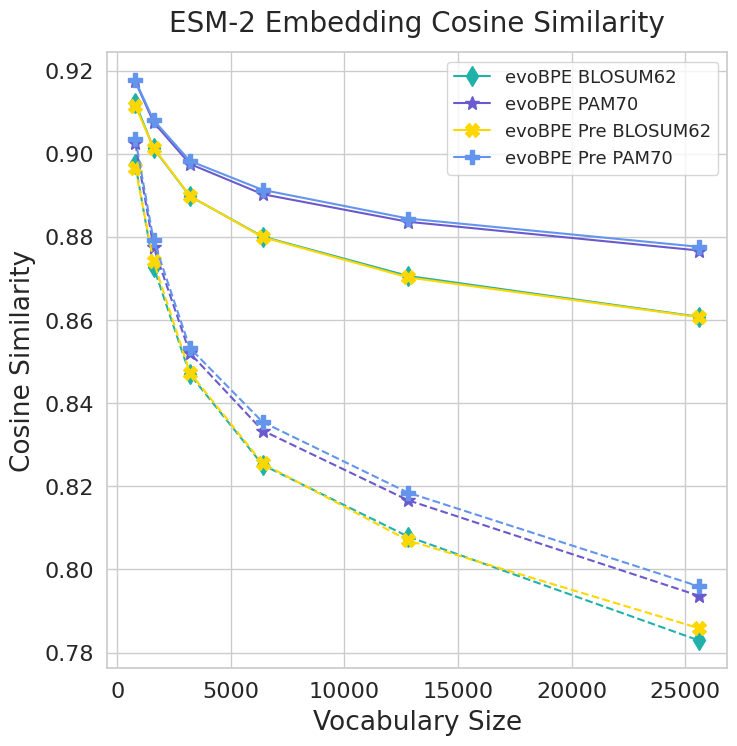

In [81]:
sns.set_style("whitegrid")

for i, method in enumerate(methods):
    for j, choice in enumerate(['mutated', 'alternative']):
        if choice == 'mutated':
            plt.plot(vocab_sizes, [series_protein_all_similarity_wmean[f'{method} {vocab_size} {choice}'] for vocab_size in vocab_sizes],
                    markers[i],
                    color=colors[i],
                    linestyle=linestyles[j],
                    markersize=10,
                    label=methods2names[method])
        else:
            plt.plot(vocab_sizes, [series_protein_all_similarity_wmean[f'{method} {vocab_size} {choice}'] for vocab_size in vocab_sizes],
                    markers[i],
                    color=colors[i],
                    linestyle=linestyles[j],
                    markersize=10)

plt.title(f"ESM-2 Embedding Cosine Similarity", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Cosine Similarity", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
# plt.ylim([.1, .4])

plt.savefig(f'{figures_folder_name}/esm_embedding_all.eps', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/esm_embedding_all.pdf', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/esm_embedding_all.png', bbox_inches='tight')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


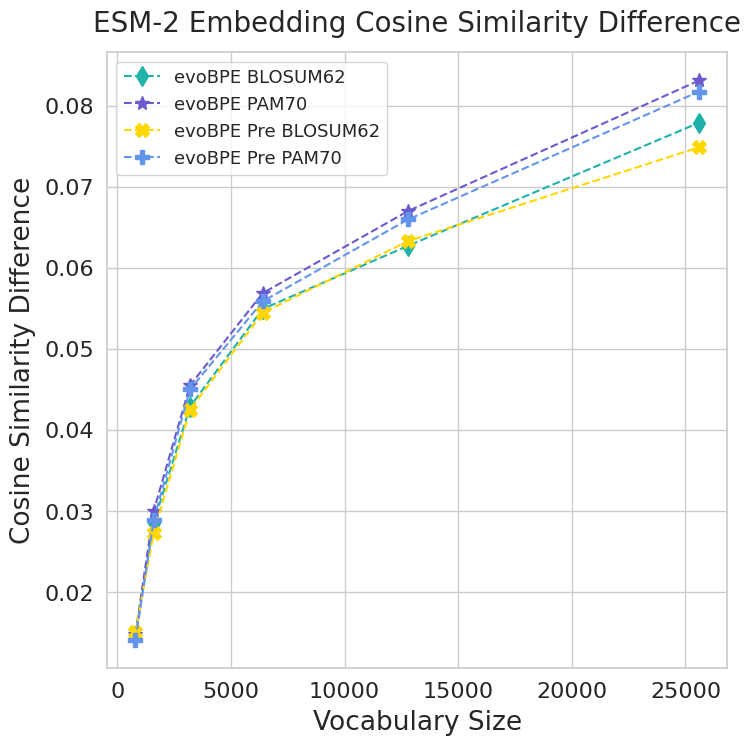

In [82]:
sns.set_style("whitegrid")
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, 
             [series_protein_all_similarity_wmean[f'{method} {vocab_size} mutated']-series_protein_all_similarity_wmean[f'{method} {vocab_size} alternative']
              for vocab_size in vocab_sizes],
            markers[i],
            color=colors[i],
            linestyle=linestyles[1],
            markersize=10,
            label=methods2names[method])

plt.title(f"ESM-2 Embedding Cosine Similarity Difference", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Cosine Similarity Difference", labelpad=label_pad)
# plt.xticks(vocab_sizes)
plt.legend()

# plt.xlim([0, 2000])
# plt.ylim([1.9, 16.1])

plt.savefig(f'{figures_folder_name}/esm_embedding_diff.eps', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/esm_embedding_diff.pdf', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/esm_embedding_diff.png', bbox_inches='tight')

plt.show()